In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.datasets import cifar100
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
print('tensorflow', tf.__version__)

tensorflow 2.10.1


In [2]:
# checkpoint_filepath = './check.h5'
# callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True
# )

# reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_accuracy',
#     mode='max',
#     factor=0.8,
#     patience=3,
#     cooldown=0,
#     min_lr=0.000001,
#     verbose=1
# )
# callback_Earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3)
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)

In [3]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape = (224, 224, 3)
)
base_model.trainable = False

for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [4]:
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Model

# input_shape = (32, 32, 3)

# model_input = tf.keras.layers.Input(shape=input_shape)
# upsampled_input = UpSampling2D(size=(7, 7), interpolation='bicubic')(model_input)
# x = base_model(upsampled_input)
# x = Flatten()(x)
# predictions = tf.keras.layers.Dense(100, activation='softmax', name='model_output')(x)

# model = Model(model_input, predictions)
# model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [5]:
print(base_model.summary())
# print('----------------------------------------------------------')
# for layer in base_model.layers:
#     print(layer.name, ' is  trainable? ', layer.trainable)


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

資料集前處理

In [6]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)
y_test = to_categorical(y_test, num_classes = 100)
x_train = x_train * 1.0/255
x_val = x_val * 1.0/255
x_test = x_test *1.0/255
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

train_datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)
train_datagen.fit(x_train)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


In [7]:
history=model.fit(
    train_datagen.flow(x_train, y_train, batch_size=128),
    validation_data = (x_val, y_val),
    epochs = 100,
    verbose = 1,
    callbacks = [learning_rate_reduction]
    #callbacks = [callback_checkpoint, reduce_learning_rate, callback_Earlystop]
)

Epoch 1/100
313/313 [==============================] - 102s 321ms/step - loss: 4.2384 - accuracy: 0.0928 - val_loss: 15.5571 - val_accuracy: 0.0098 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 98s 313ms/step - loss: 3.1531 - accuracy: 0.2509 - val_loss: 10.9749 - val_accuracy: 0.0130 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 99s 317ms/step - loss: 2.7297 - accuracy: 0.3295 - val_loss: 3.7160 - val_accuracy: 0.1489 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 99s 317ms/step - loss: 2.4951 - accuracy: 0.3738 - val_loss: 2.2850 - val_accuracy: 0.4181 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 99s 317ms/step - loss: 2.3535 - accuracy: 0.4018 - val_loss: 2.1062 - val_accuracy: 0.4618 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 99s 316ms/step - loss: 2.2355 - accuracy: 0.4259 - val_loss: 2.0880 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 7/100
313/313 [======================

模型評估

In [8]:
import matplotlib.pyplot as plt
def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()
  loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
  print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

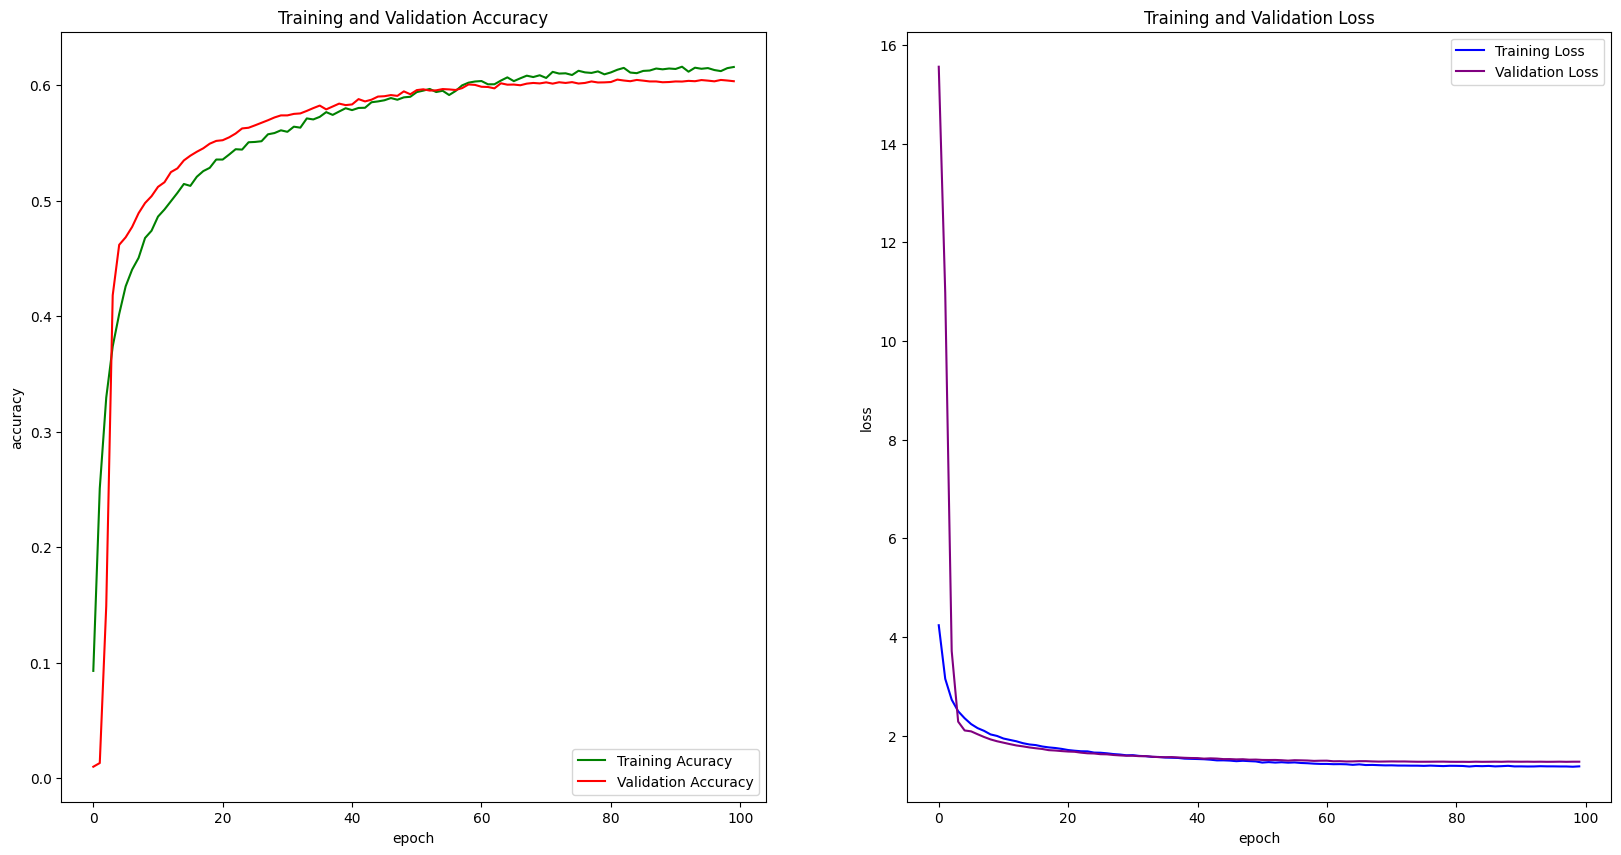

Testing Accuracy = 58.90 %    loss = 1.495852


In [9]:
plot_acc_loss(history)

載入權重

In [10]:
#model.load_weights(checkpoint_filepath)

再次訓練

In [11]:
# history2=model.fit(
#     train_datagen.flow(x_train, y_train, batch_size=128),
#     validation_data = (x_val, y_val),
#     epochs = 30,
#     verbose = 1,
#     callbacks = [callback_checkpoint, reduce_learning_rate, callback_Earlystop]
# )

模型評估

In [12]:
# loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
# print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))